In [30]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

from policy import PolicyNN
from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [31]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
print(df_all.shape)
print(df_all.columns.tolist())

(610615, 12)
['time_index', 'melt_pool_temperature', 'melt_pool_depth', 'scanning_speed', 'X', 'Y', 'Z', 'Dist_to_nearest_X', 'Dist_to_nearest_Y', 'Dist_to_nearest_Z', 'Laser_power', 'laser_power_number']


In [32]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


[np.float64(0.0), np.float64(0.75), np.float64(0.8678160668808631), np.float64(1.1358663262803783), np.float64(1.403916585679894), np.float64(1.5), np.float64(1.5211383161901857), np.float64(1.789188575589701), np.float64(2.0572388349892163), np.float64(2.25), np.float64(2.442510824899036), np.float64(2.710561084298586), np.float64(2.978611343698029), np.float64(3.0), np.float64(3.095833074208392), np.float64(3.3638833336079417), np.float64(3.631933593007492), np.float64(3.75), np.float64(4.017205957917313), np.float64(4.285256217316901), np.float64(4.5), np.float64(4.670527682226559), np.float64(4.938577941626146), np.float64(5.206628201025734), np.float64(5.25), np.float64(5.323850156536165), np.float64(5.591900415935463), np.float64(5.859950675334975), np.float64(6.0), np.float64(6.245222890244975), np.float64(6.513273149644562), np.float64(6.75), np.float64(6.898544614554391), np.float64(7.166594873953689), np.float64(7.434645133353201), np.float64(7.5)]


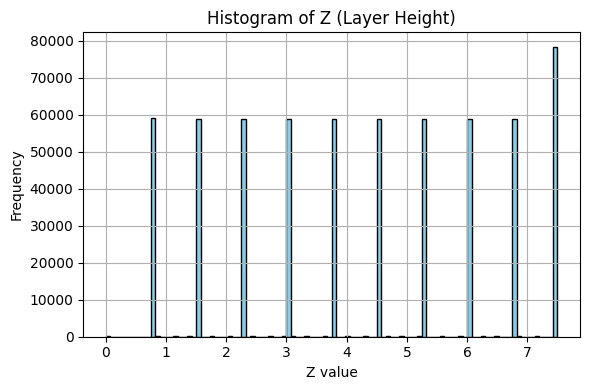

Total samples: 610615
Key Z values: 608093 (99.59%)
Other Z values: 2522 (0.41%)


In [33]:
# Z 컬럼의 고유한 값들 확인 (정렬 포함)
unique_z_values = sorted(df_all['Z'].unique())
print(unique_z_values)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df_all['Z'], bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Z value')
plt.ylabel('Frequency')
plt.title('Histogram of Z (Layer Height)')
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 조건별 개수 계산
is_key = df_all['Z'].isin(key_z_values)
n_key = is_key.sum()
n_total = len(df_all)
n_other = n_total - n_key

# 비율 출력
print(f"Total samples: {n_total}")
print(f"Key Z values: {n_key} ({n_key / n_total:.2%})")
print(f"Other Z values: {n_other} ({n_other / n_total:.2%})")

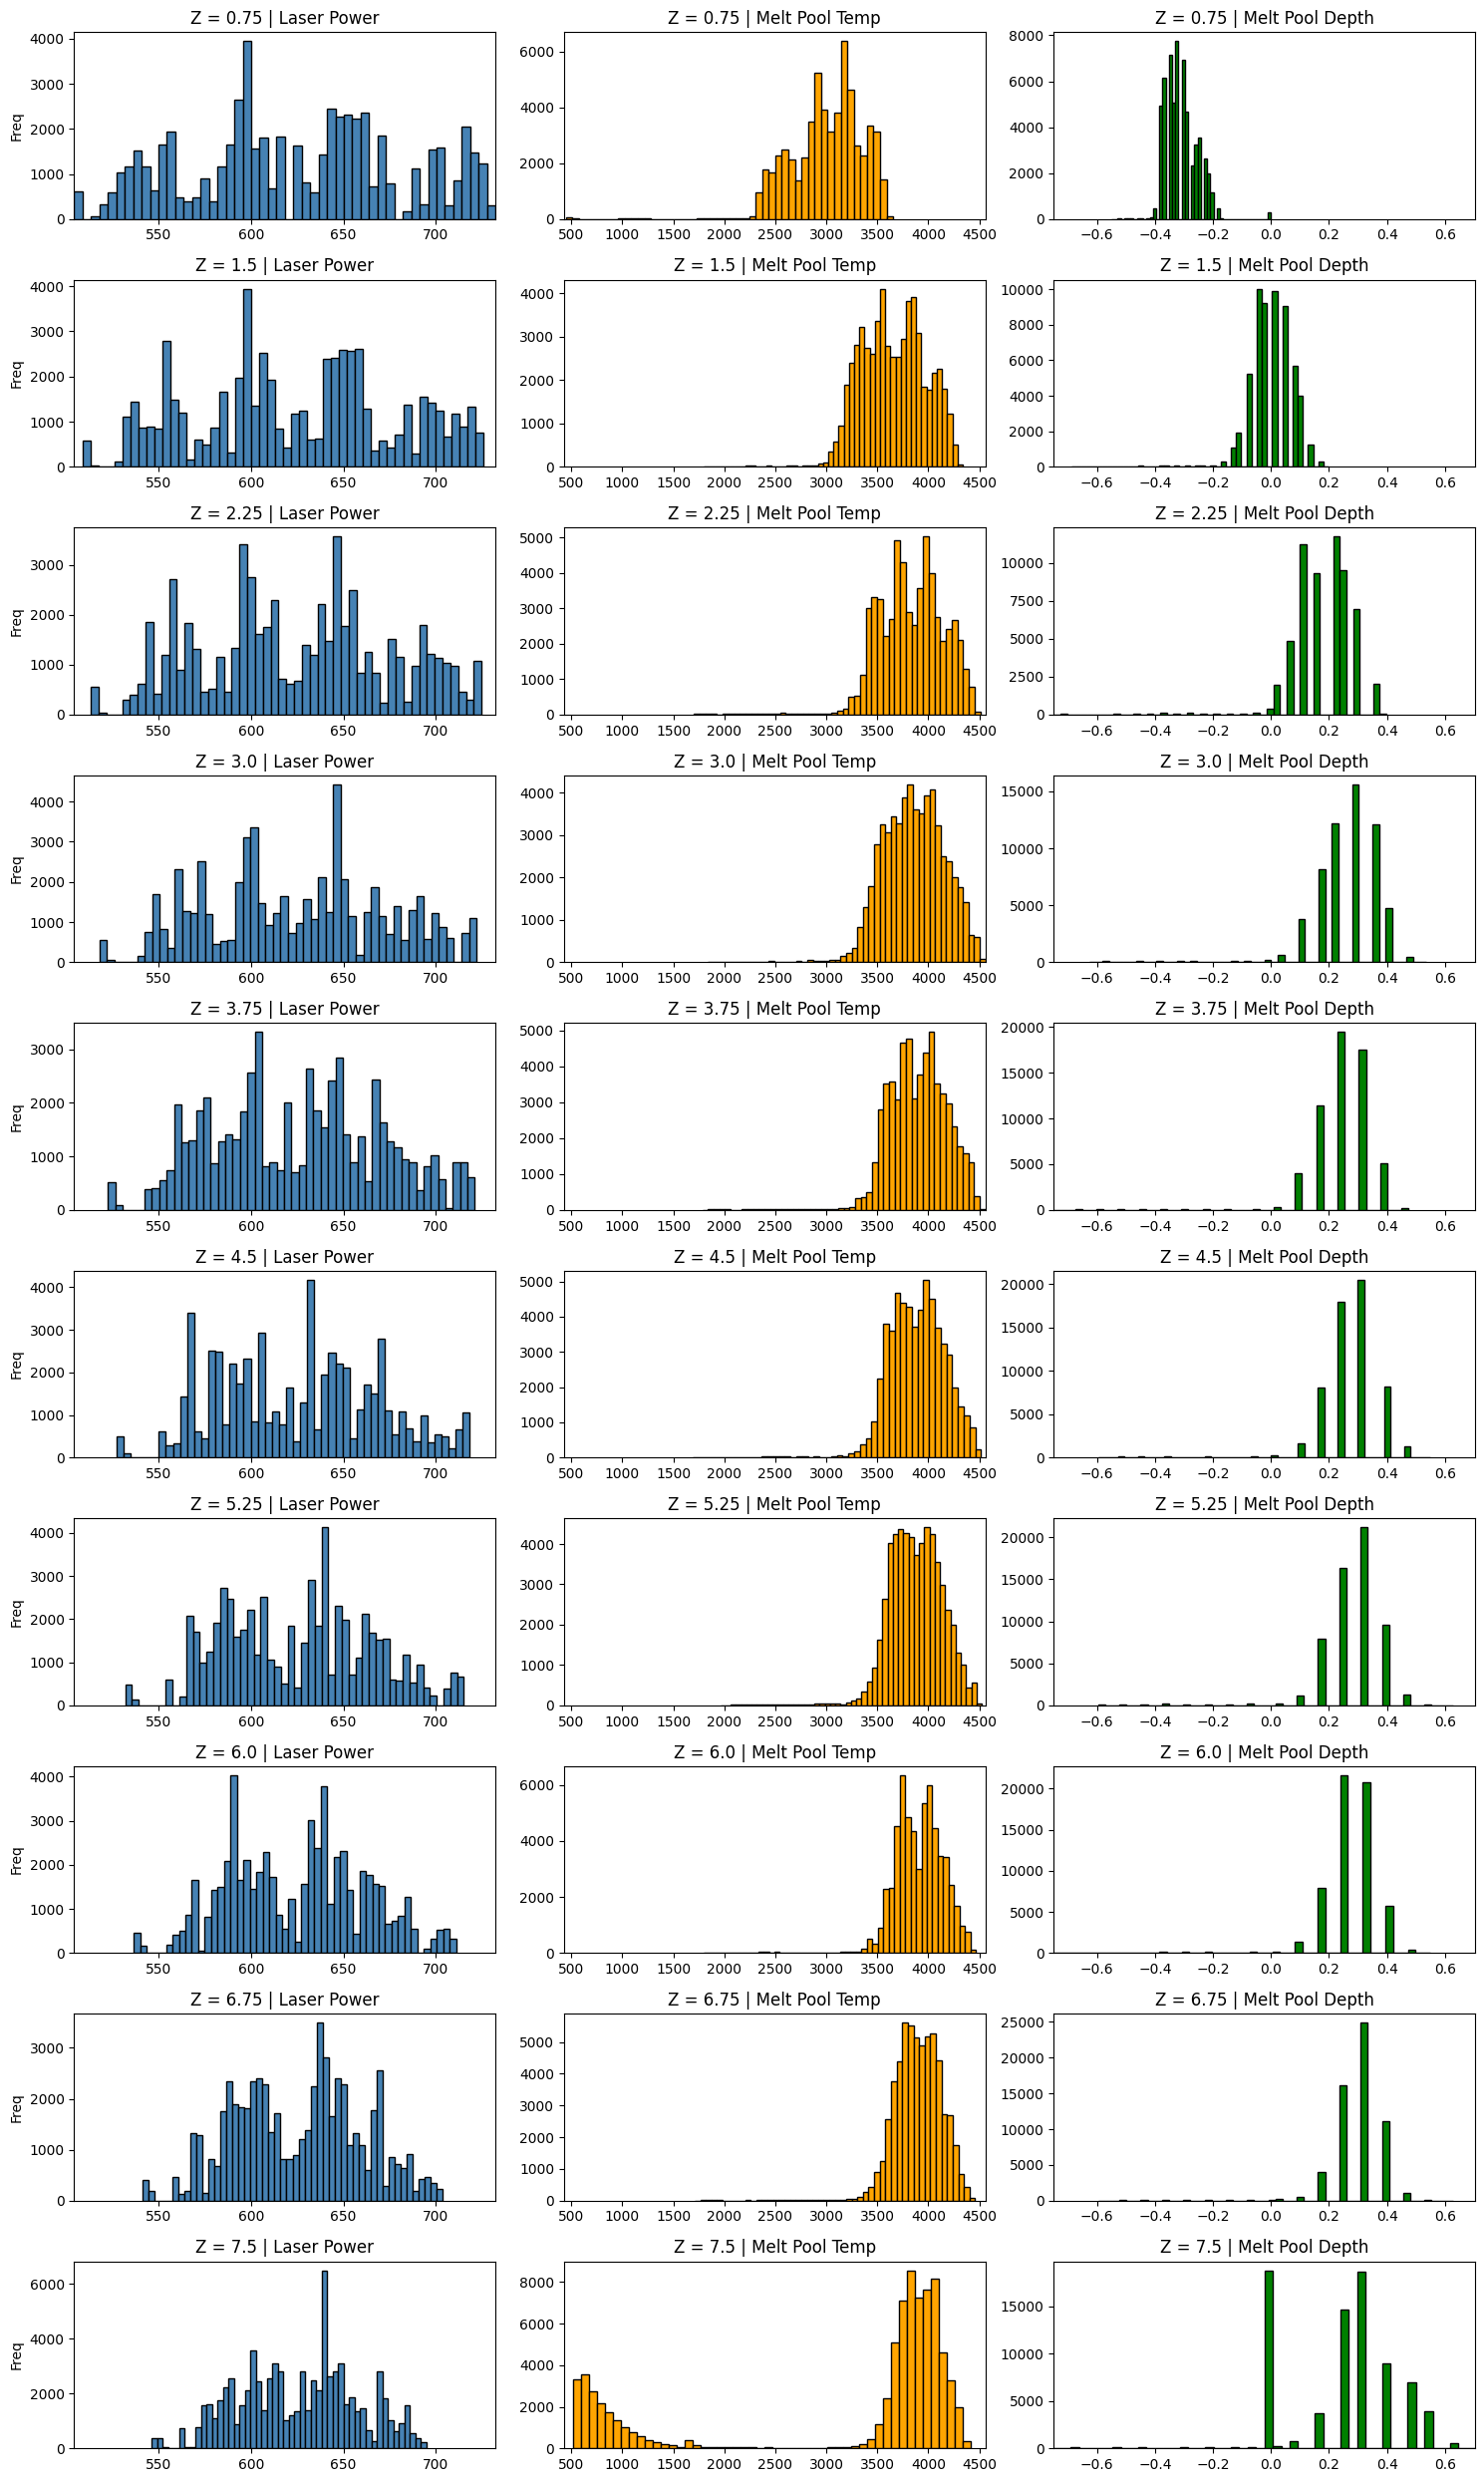

In [34]:
import matplotlib.pyplot as plt

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 각 변수별로 전체 데이터에서 공통 축 범위 구하기
xlims = {
    'Laser_power': (df_all['Laser_power'].min(), df_all['Laser_power'].max()),
    'melt_pool_temperature': (df_all['melt_pool_temperature'].min(), df_all['melt_pool_temperature'].max()),
    'melt_pool_depth': (df_all['melt_pool_depth'].min(), df_all['melt_pool_depth'].max())
}

# subplot 구조: n행 × 3열
n = len(key_z_values)
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, n * 2.5), sharex=False)

for i, z_val in enumerate(key_z_values):
    subset = df_all[df_all['Z'] == z_val]

    # (1) Laser_power
    axes[i, 0].hist(subset['Laser_power'], bins=50, color='steelblue', edgecolor='black')
    axes[i, 0].set_title(f'Z = {z_val} | Laser Power')
    axes[i, 0].set_xlim(xlims['Laser_power'])
    axes[i, 0].set_ylabel('Freq')

    # (2) melt_pool_temperature
    axes[i, 1].hist(subset['melt_pool_temperature'], bins=50, color='orange', edgecolor='black')
    axes[i, 1].set_title(f'Z = {z_val} | Melt Pool Temp')
    axes[i, 1].set_xlim(xlims['melt_pool_temperature'])

    # (3) melt_pool_depth
    axes[i, 2].hist(subset['melt_pool_depth'], bins=50, color='green', edgecolor='black')
    axes[i, 2].set_title(f'Z = {z_val} | Melt Pool Depth')
    axes[i, 2].set_xlim(xlims['melt_pool_depth'])

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()


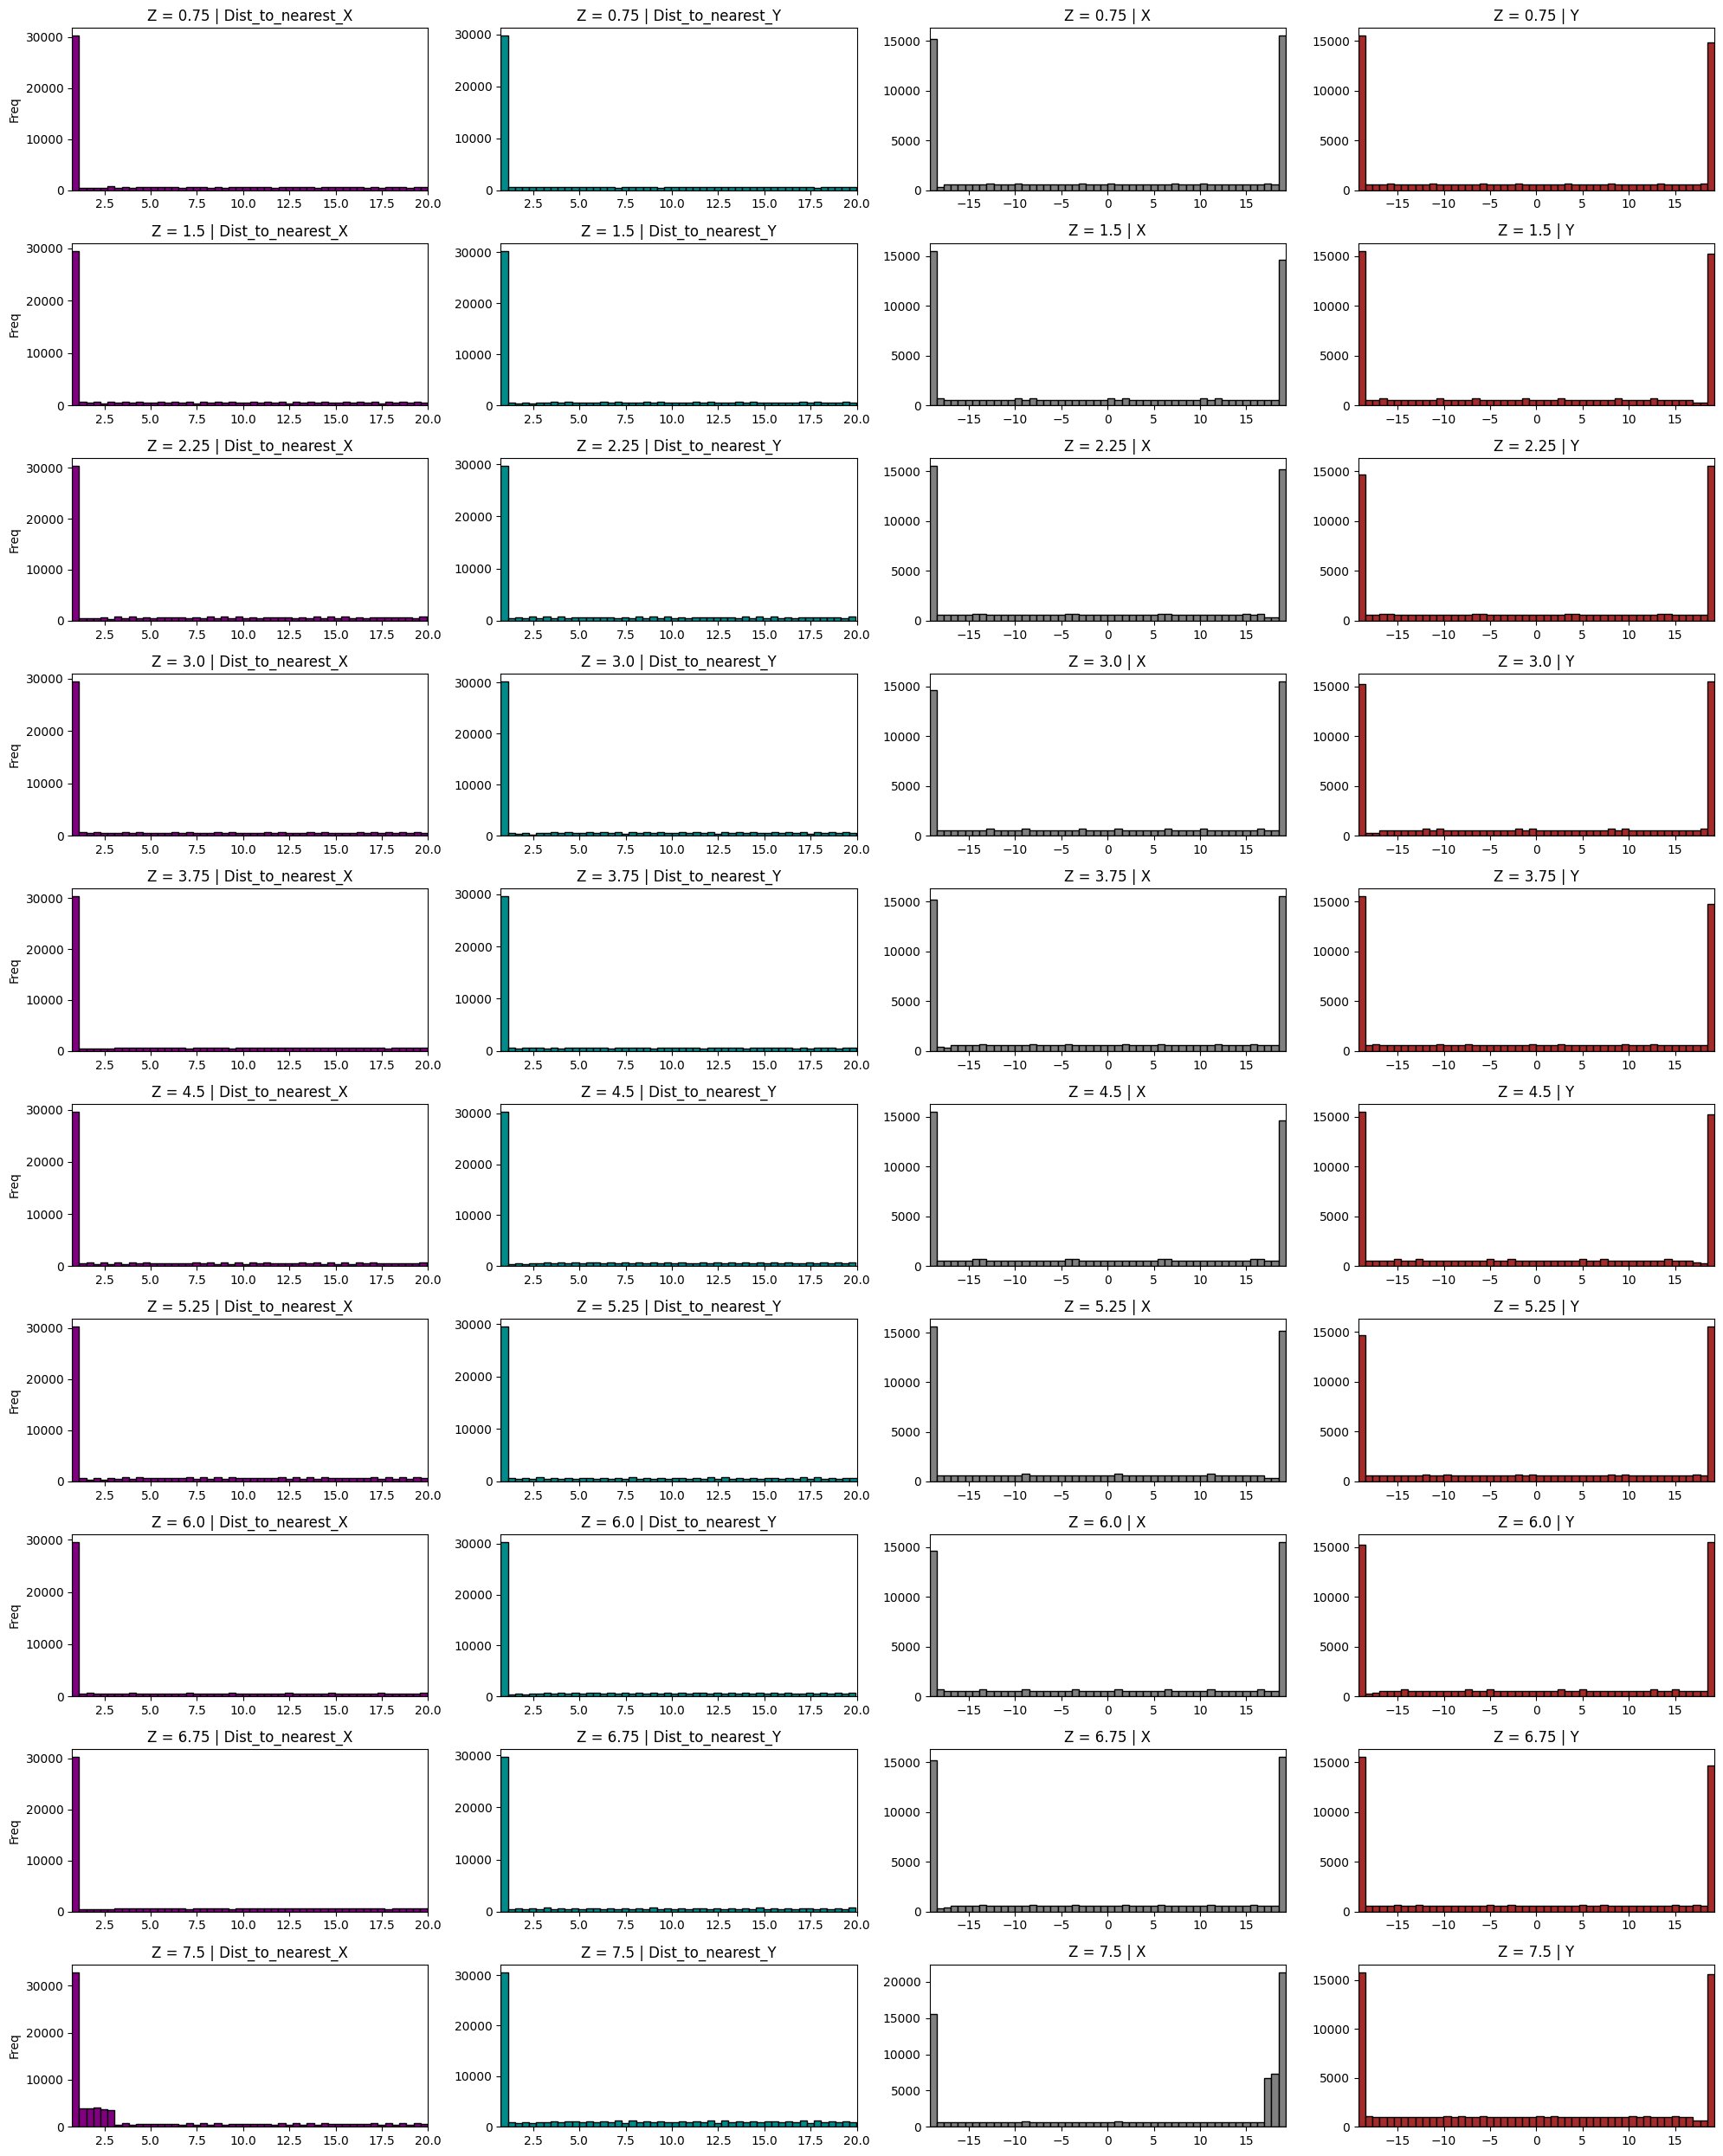

In [35]:
import matplotlib.pyplot as plt

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 각 변수별 x축 범위 고정
xlims = {
    'Dist_to_nearest_X': (df_all['Dist_to_nearest_X'].min(), df_all['Dist_to_nearest_X'].max()),
    'Dist_to_nearest_Y': (df_all['Dist_to_nearest_Y'].min(), df_all['Dist_to_nearest_Y'].max()),
    'X': (df_all['X'].min(), df_all['X'].max()),
    'Y': (df_all['Y'].min(), df_all['Y'].max())
}

# subplot: n행 × 4열
n = len(key_z_values)
fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(20, n * 2.5), sharex=False)

for i, z_val in enumerate(key_z_values):
    subset = df_all[df_all['Z'] == z_val]

    # (1) Dist_to_nearest_X
    axes[i, 0].hist(subset['Dist_to_nearest_X'], bins=50, color='purple', edgecolor='black')
    axes[i, 0].set_title(f'Z = {z_val} | Dist_to_nearest_X')
    axes[i, 0].set_xlim(xlims['Dist_to_nearest_X'])
    axes[i, 0].set_ylabel('Freq')

    # (2) Dist_to_nearest_Y
    axes[i, 1].hist(subset['Dist_to_nearest_Y'], bins=50, color='darkcyan', edgecolor='black')
    axes[i, 1].set_title(f'Z = {z_val} | Dist_to_nearest_Y')
    axes[i, 1].set_xlim(xlims['Dist_to_nearest_Y'])

    # (3) X
    axes[i, 2].hist(subset['X'], bins=50, color='gray', edgecolor='black')
    axes[i, 2].set_title(f'Z = {z_val} | X')
    axes[i, 2].set_xlim(xlims['X'])

    # (4) Y
    axes[i, 3].hist(subset['Y'], bins=50, color='brown', edgecolor='black')
    axes[i, 3].set_title(f'Z = {z_val} | Y')
    axes[i, 3].set_xlim(xlims['Y'])

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()


In [36]:
# 전체 샘플 수
n_total = len(df_all)

# Dist_to_nearest_X
is_x_leq_075 = df_all['Dist_to_nearest_X'] <= 0.75
n_x_leq_075 = is_x_leq_075.sum()
n_x_gt_075 = n_total - n_x_leq_075

# Dist_to_nearest_Y
is_y_leq_075 = df_all['Dist_to_nearest_Y'] <= 0.75
n_y_leq_075 = is_y_leq_075.sum()
n_y_gt_075 = n_total - n_y_leq_075

# 결과 출력
print("Dist_to_nearest_X:")
print(f"  ≤ 0.75: {n_x_leq_075} ({n_x_leq_075 / n_total:.2%})")
print(f"  > 0.75: {n_x_gt_075} ({n_x_gt_075 / n_total:.2%})")

print("Dist_to_nearest_Y:")
print(f"  ≤ 0.75: {n_y_leq_075} ({n_y_leq_075 / n_total:.2%})")
print(f"  > 0.75: {n_y_gt_075} ({n_y_gt_075 / n_total:.2%})")


Dist_to_nearest_X:
  ≤ 0.75: 294104 (48.17%)
  > 0.75: 316511 (51.83%)
Dist_to_nearest_Y:
  ≤ 0.75: 294492 (48.23%)
  > 0.75: 316123 (51.77%)


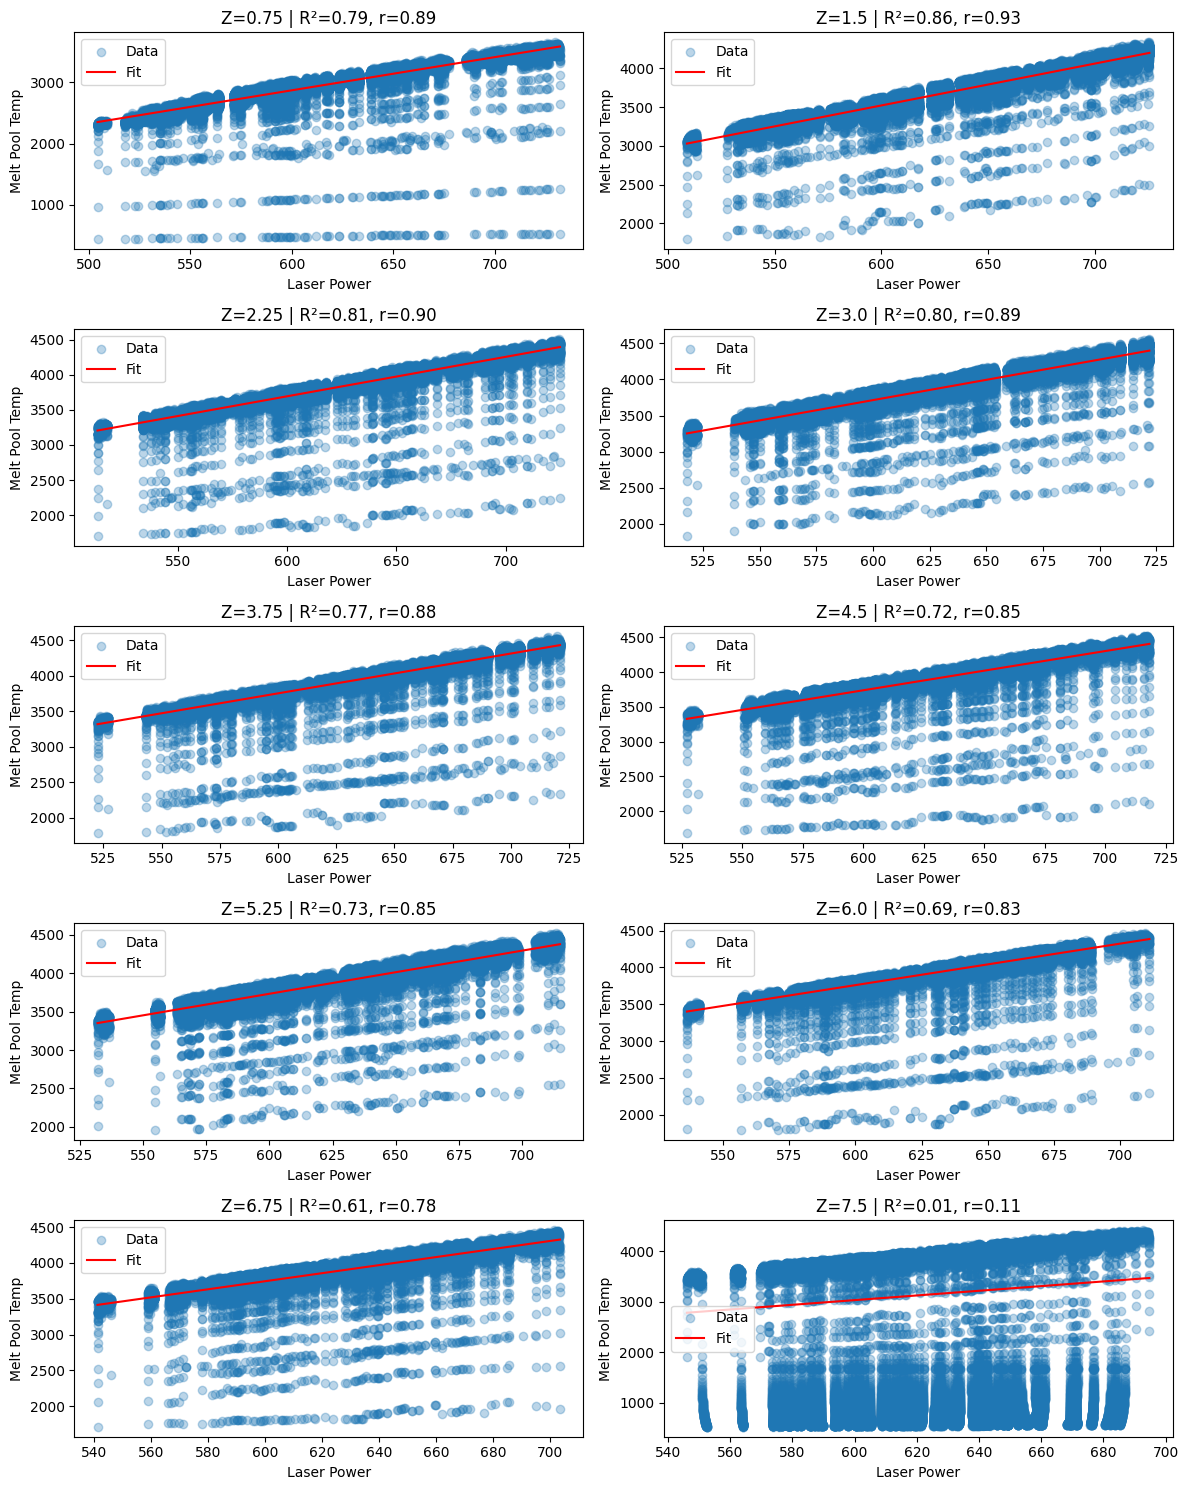

      Z  Pearson_r      Pearson_p  Spearman_r  Spearman_p     Slope  \
0  0.75   0.887934   0.000000e+00    0.964065         0.0  5.407743   
1  1.50   0.929024   0.000000e+00    0.956949         0.0  5.392480   
2  2.25   0.898990   0.000000e+00    0.961959         0.0  5.631479   
3  3.00   0.893134   0.000000e+00    0.939426         0.0  5.617996   
4  3.75   0.877323   0.000000e+00    0.962063         0.0  5.613262   
5  4.50   0.848190   0.000000e+00    0.944122         0.0  5.639494   
6  5.25   0.854768   0.000000e+00    0.924024         0.0  5.610474   
7  6.00   0.828721   0.000000e+00    0.952380         0.0  5.638961   
8  6.75   0.780166   0.000000e+00    0.912576         0.0  5.628689   
9  7.50   0.109506  7.298876e-207    0.524721         0.0  4.631173   

    Intercept        R2  
0 -375.020071  0.788426  
1  285.942849  0.863086  
2  315.448099  0.808184  
3  342.255313  0.797688  
4  383.531401  0.769696  
5  355.104686  0.719426  
6  367.279298  0.730628  
7  377.009

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

results = []

# subplot 설정 (2열 구조)
n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)  # axes indexing robustness

plot_idx = 0  # 실제 그려진 subplot 수

for z_val in key_z_values:
    # Z별 subset 및 NaN 제거
    subset = df_all[df_all['Z'] == z_val][['Laser_power', 'melt_pool_temperature']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data after NaN removal, skipped.")
        continue

    # 상관계수
    pearson_r, pearson_p = pearsonr(subset['Laser_power'], subset['melt_pool_temperature'])
    spearman_r, spearman_p = spearmanr(subset['Laser_power'], subset['melt_pool_temperature'])

    # 선형 회귀
    X = subset[['Laser_power']].values
    y = subset['melt_pool_temperature'].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)

    # 결과 저장
    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Pearson_p': pearson_p,
        'Spearman_r': spearman_r,
        'Spearman_p': spearman_p,
        'Slope': slope,
        'Intercept': intercept,
        'R2': r2
    })

    # subplot 위치 계산
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    # 시각화
    ax.scatter(X, y, alpha=0.3, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_vals)
    ax.plot(x_vals, y_pred, color='red', label='Fit')
    ax.set_title(f'Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}')
    ax.set_xlabel('Laser Power')
    ax.set_ylabel('Melt Pool Temp')
    ax.legend()

# 빈 subplot 처리 (남는 칸 비우기)
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# 결과 요약 출력
results_df = pd.DataFrame(results)
print(results_df)


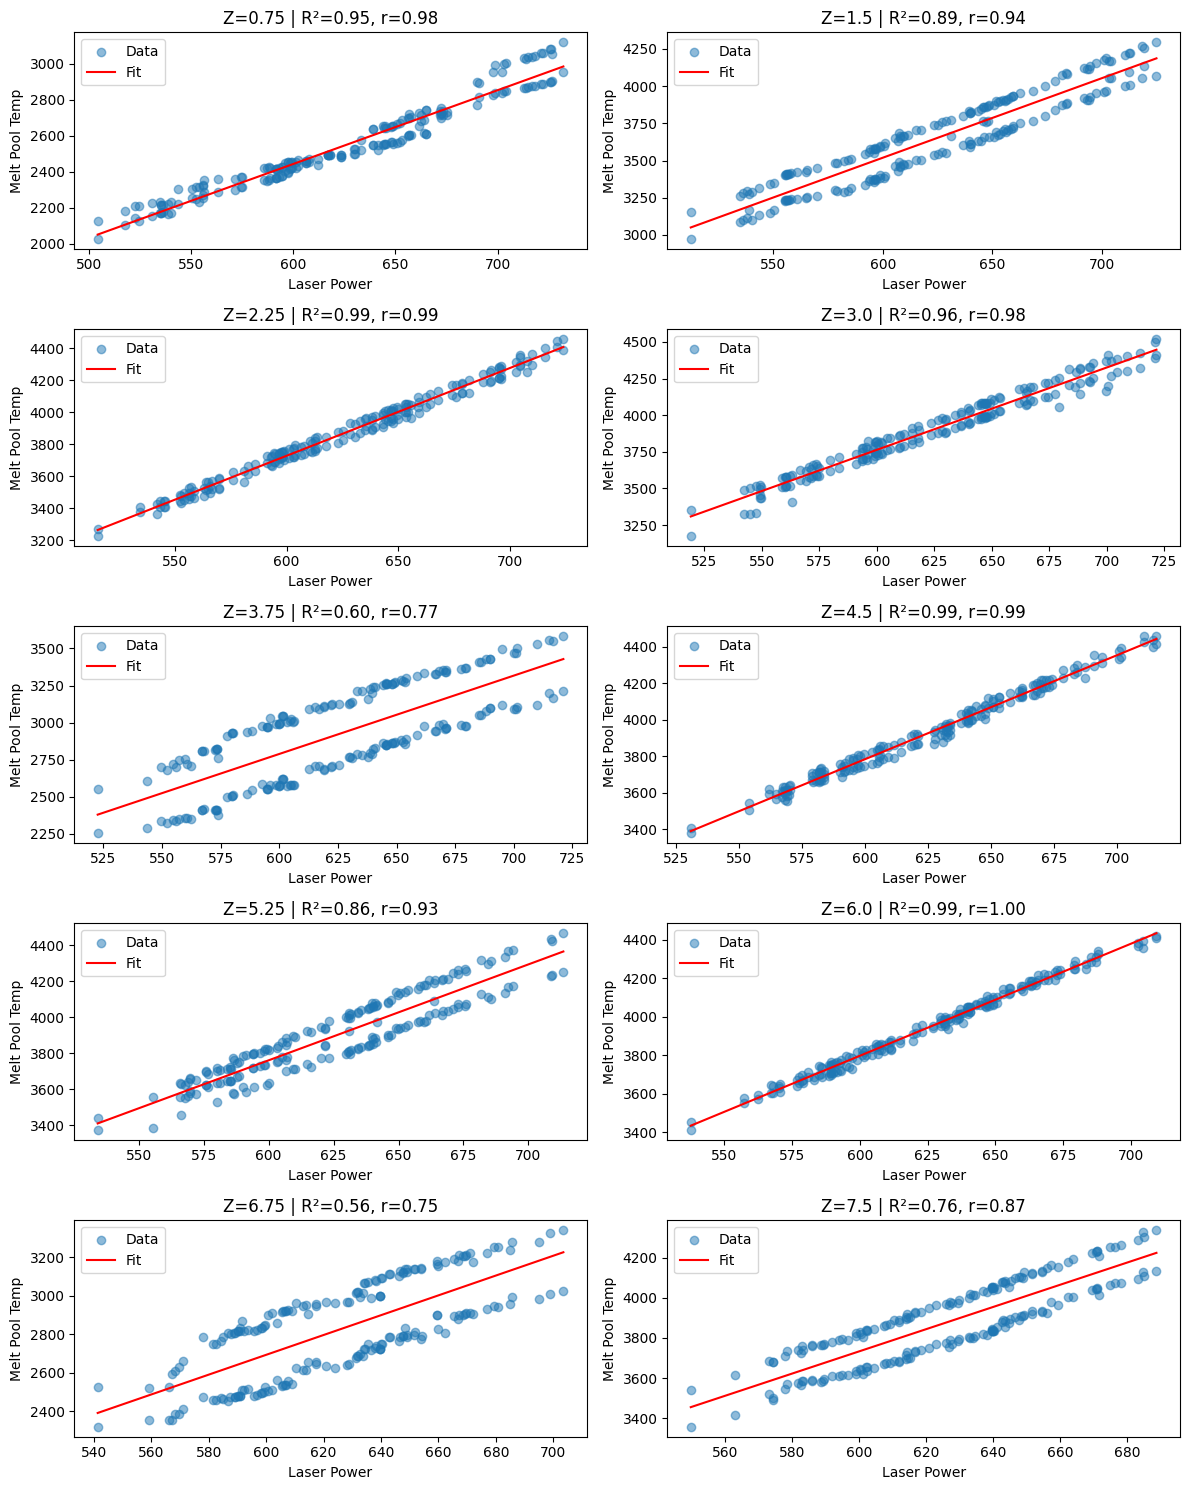

      Z  Pearson_r     Slope        R2
0  0.75   0.975291  4.099625  0.951193
1  1.50   0.943414  5.335474  0.890030
2  2.25   0.993470  5.497847  0.986983
3  3.00   0.981829  5.621714  0.963988
4  3.75   0.773882  5.282001  0.598894
5  4.50   0.992879  5.701957  0.985810
6  5.25   0.928936  5.329773  0.862923
7  6.00   0.995701  5.824843  0.991421
8  6.75   0.746699  5.151475  0.557560
9  7.50   0.873652  5.527402  0.763268


In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 위치 필터링 조건
x_range = (-16.5,-16)
y_target = 19.25
y_tol = 0.01  # 허용 오차

results = []

n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)

plot_idx = 0

for z_val in key_z_values:
    # 필터링 조건 적용
    subset = df_all[
        (df_all['Z'] == z_val) &
        (df_all['X'] >= x_range[0]) & (df_all['X'] <= x_range[1]) &
        (df_all['Y'].between(y_target - y_tol, y_target + y_tol))
    ][['Laser_power', 'melt_pool_temperature']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data after spatial filter, skipped.")
        continue

    # 상관 분석 및 회귀
    pearson_r, _ = pearsonr(subset['Laser_power'], subset['melt_pool_temperature'])
    X = subset[['Laser_power']].values
    y = subset['melt_pool_temperature'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Slope': slope,
        'R2': r2
    })

    # 시각화
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    ax.scatter(X, y, alpha=0.5, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    ax.plot(x_vals, model.predict(x_vals), color='red', label='Fit')
    ax.set_title(f"Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}")
    ax.set_xlabel("Laser Power")
    ax.set_ylabel("Melt Pool Temp")
    ax.legend()

# 빈 subplot 비우기
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)


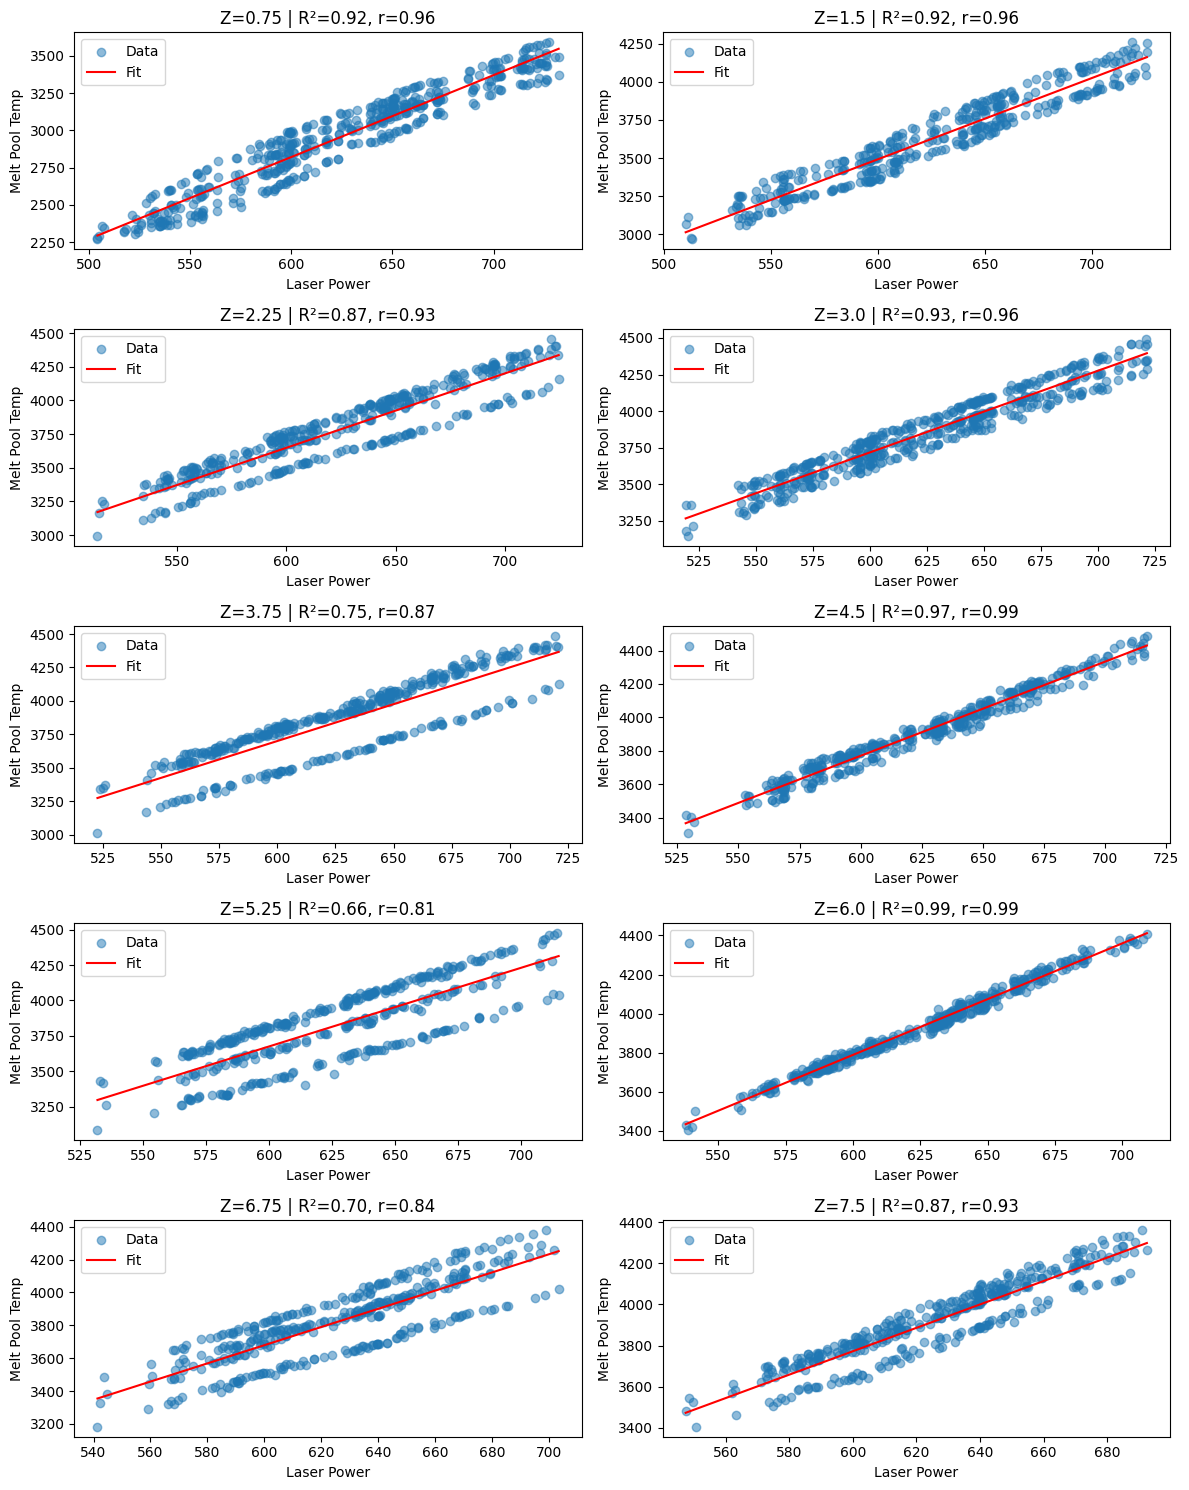

      Z  Pearson_r     Slope        R2
0  0.75   0.960682  5.498513  0.922911
1  1.50   0.961728  5.323981  0.924921
2  2.25   0.930365  5.512846  0.865579
3  3.00   0.964981  5.573134  0.931187
4  3.75   0.868327  5.504856  0.753992
5  4.50   0.986418  5.636421  0.973021
6  5.25   0.810113  5.552856  0.656283
7  6.00   0.993836  5.705747  0.987710
8  6.75   0.839467  5.532497  0.704705
9  7.50   0.934068  5.684164  0.872483


In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 거리 필터링 조건
dist_x_range = (5, 5.26)
dist_y_range = (0, 76)

results = []

# subplot 설정
n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)

plot_idx = 0

for z_val in key_z_values:
    # 조건에 맞는 데이터 필터링
    subset = df_all[
        (df_all['Z'] == z_val) &
        (df_all['Dist_to_nearest_X'].between(dist_x_range[0], dist_x_range[1])) &
        (df_all['Dist_to_nearest_Y'].between(dist_y_range[0], dist_y_range[1]))
    ][['Laser_power', 'melt_pool_temperature']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data after distance filter, skipped.")
        continue

    # 상관계수 및 회귀
    pearson_r, _ = pearsonr(subset['Laser_power'], subset['melt_pool_temperature'])
    X = subset[['Laser_power']].values
    y = subset['melt_pool_temperature'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    slope = model.coef_[0]

    # 결과 저장
    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Slope': slope,
        'R2': r2
    })

    # 시각화
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    ax.scatter(X, y, alpha=0.5, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    ax.plot(x_vals, model.predict(x_vals), color='red', label='Fit')
    ax.set_title(f"Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}")
    ax.set_xlabel("Laser Power")
    ax.set_ylabel("Melt Pool Temp")
    ax.legend()

# 빈 subplot 비우기
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)


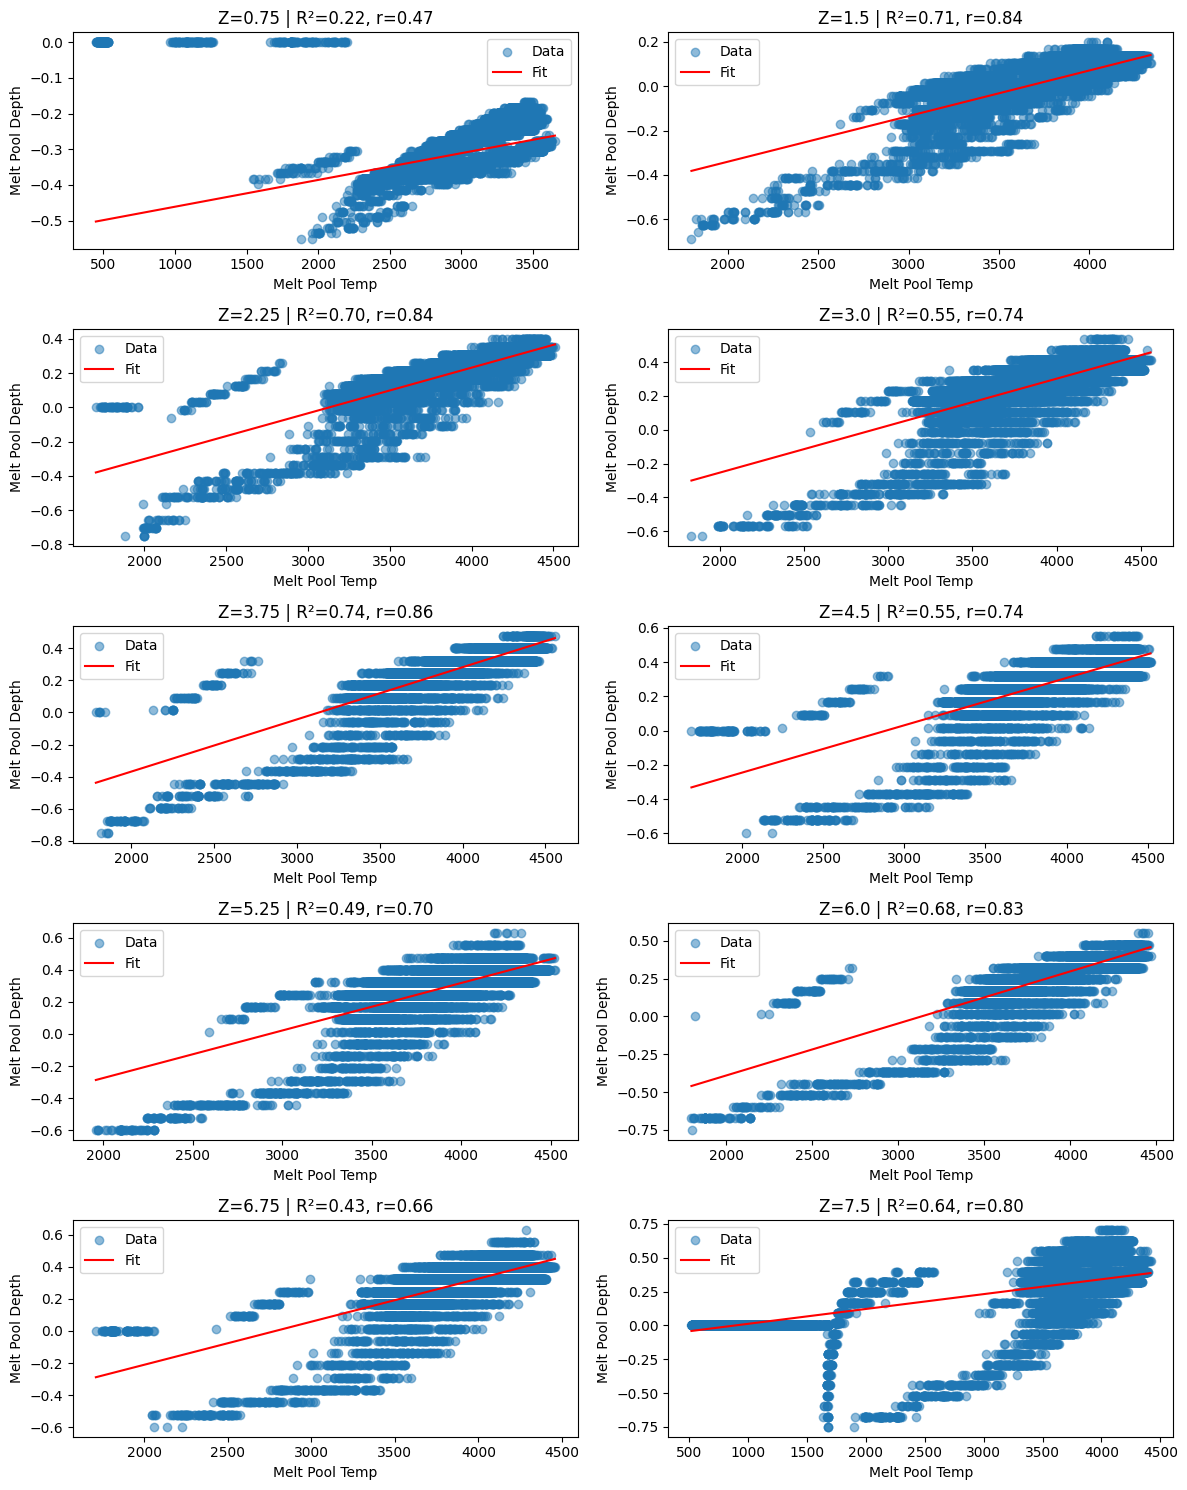

      Z  Pearson_r     Slope        R2
0  0.75   0.465782  0.000075  0.216953
1  1.50   0.843461  0.000206  0.711426
2  2.25   0.835256  0.000266  0.697653
3  3.00   0.741061  0.000278  0.549171
4  3.75   0.857909  0.000325  0.736007
5  4.50   0.738937  0.000276  0.546027
6  5.25   0.699346  0.000296  0.489084
7  6.00   0.826144  0.000344  0.682515
8  6.75   0.659355  0.000268  0.434749
9  7.50   0.799431  0.000110  0.639090


In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

results = []

# subplot 설정 (2열)
n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)

plot_idx = 0

for z_val in key_z_values:
    subset = df_all[df_all['Z'] == z_val][['melt_pool_temperature', 'melt_pool_depth']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data, skipped.")
        continue

    # 상관 분석 + 회귀
    pearson_r, _ = pearsonr(subset['melt_pool_temperature'], subset['melt_pool_depth'])
    X = subset[['melt_pool_temperature']].values
    y = subset['melt_pool_depth'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    slope = model.coef_[0]

    # 결과 저장
    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Slope': slope,
        'R2': r2
    })

    # 시각화
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    ax.scatter(X, y, alpha=0.5, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    ax.plot(x_vals, model.predict(x_vals), color='red', label='Fit')
    ax.set_title(f"Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}")
    ax.set_xlabel("Melt Pool Temp")
    ax.set_ylabel("Melt Pool Depth")
    ax.legend()

# 빈 subplot 비우기
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)


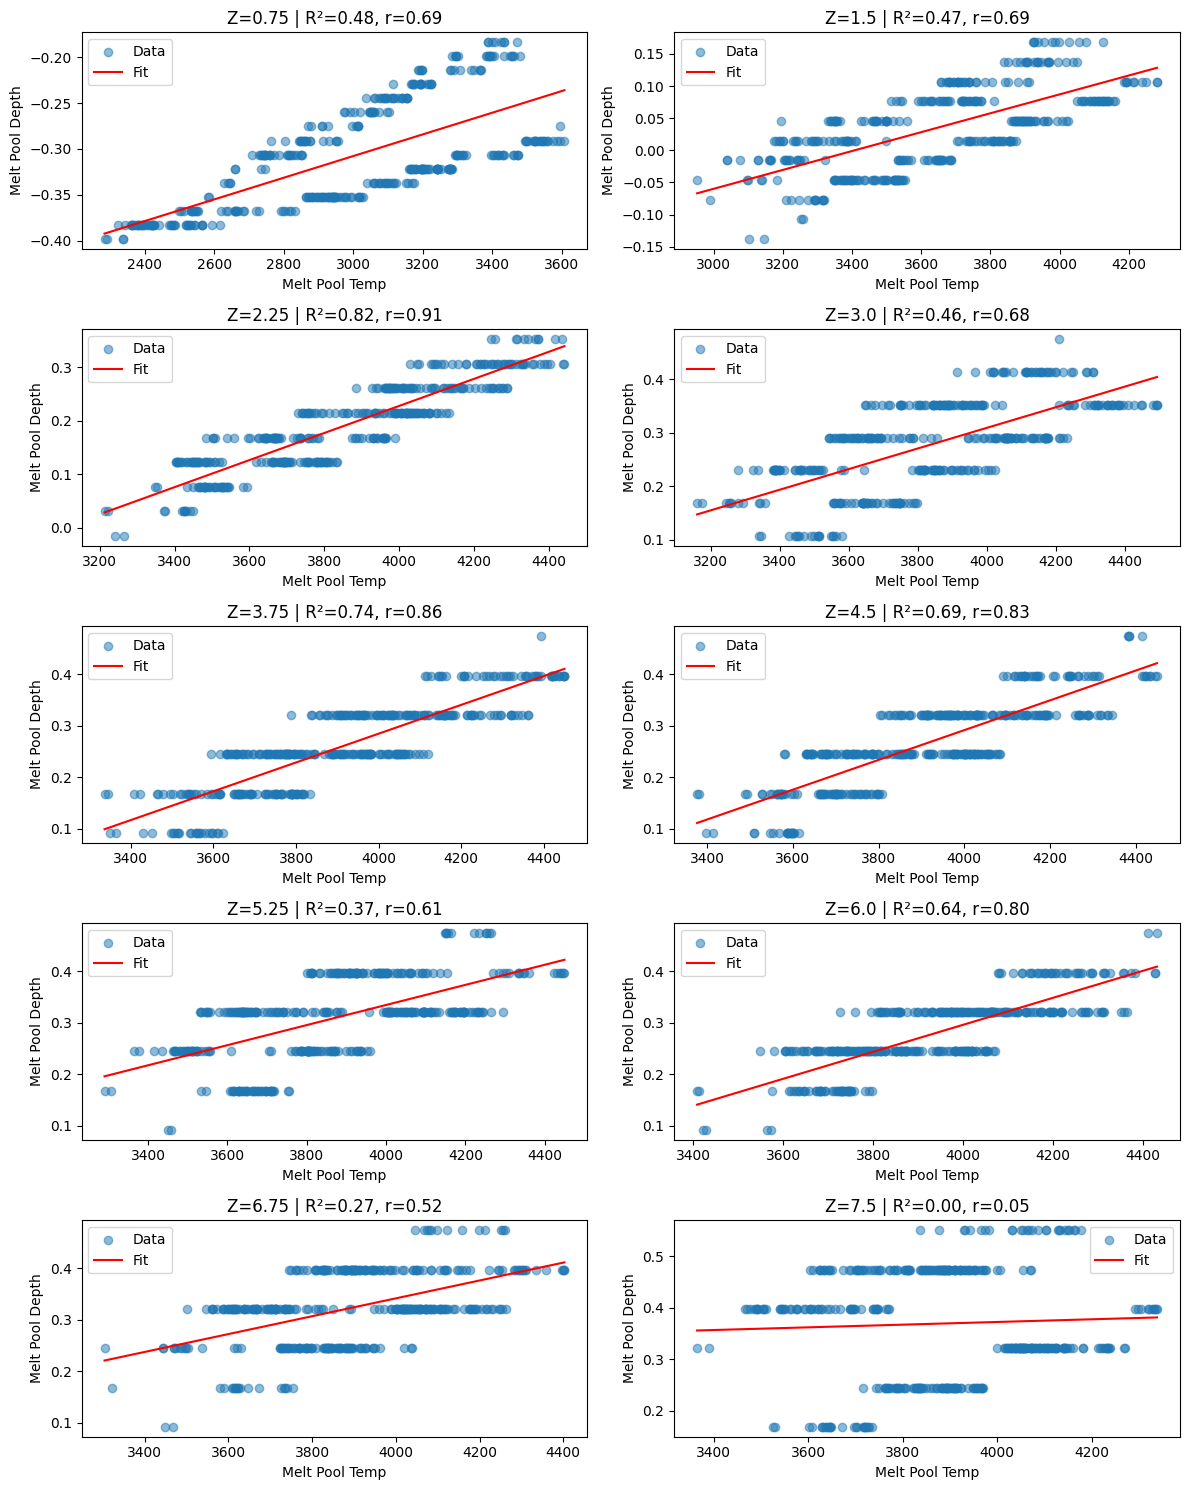

      Z  Pearson_r     Slope        R2
0  0.75   0.691154  0.000118  0.477694
1  1.50   0.686692  0.000147  0.471547
2  2.25   0.906466  0.000253  0.821681
3  3.00   0.675593  0.000193  0.456426
4  3.75   0.861519  0.000280  0.742215
5  4.50   0.831656  0.000290  0.691652
6  5.25   0.607609  0.000195  0.369188
7  6.00   0.799297  0.000262  0.638875
8  6.75   0.515585  0.000174  0.265827
9  7.50   0.048544  0.000026  0.002357


In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# 주요 Z 값 리스트
key_z_values = [0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]

# 위치 조건
x_range = (5, 6)
y_range = (19, 20)  # ε = 0.01

results = []

# subplot 구성
n_rows = (len(key_z_values) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows * 3))
axes = axes.reshape(-1, 2)

plot_idx = 0

for z_val in key_z_values:
    # 위치 조건 필터링
    subset = df_all[
        (df_all['Z'] == z_val) &
        (df_all['X'].between(x_range[0], x_range[1])) &
        (df_all['Y'].between(y_range[0], y_range[1]))  # y: [19.0, 19.24]
    ][['melt_pool_temperature', 'melt_pool_depth']].dropna()

    if len(subset) < 10:
        print(f"Z = {z_val}: insufficient data near point, skipped.")
        continue

    # 회귀 및 상관계수
    X = subset[['melt_pool_temperature']].values
    y = subset['melt_pool_depth'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    slope = model.coef_[0]
    pearson_r, _ = pearsonr(X.flatten(), y)

    results.append({
        'Z': z_val,
        'Pearson_r': pearson_r,
        'Slope': slope,
        'R2': r2
    })

    # 시각화
    row, col = divmod(plot_idx, 2)
    ax = axes[row, col]
    plot_idx += 1

    ax.scatter(X, y, alpha=0.5, label='Data')
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    ax.plot(x_vals, model.predict(x_vals), color='red', label='Fit')
    ax.set_title(f"Z={z_val} | R²={r2:.2f}, r={pearson_r:.2f}")
    ax.set_xlabel("Melt Pool Temp")
    ax.set_ylabel("Melt Pool Depth")
    ax.legend()

# 빈 subplot 제거
total_plots = len(axes.flatten())
for i in range(plot_idx, total_plots):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# 결과 요약
results_df = pd.DataFrame(results)
print(results_df)
